In [1]:
experiment=None

In [1]:
#Imports
from comet_ml import Experiment
experiment = Experiment(api_key="XXXXXXXXXXX", parse_args=False, project_name='XXXXXX')

COMET INFO: old comet version (1.0.44) detected. current: 1.0.56 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET WARNING: Failing to collect the installed os packages
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/yikeqicn/segnet/dc16e266234b4be19147ed9de3d1b794



In [2]:
#from datasets import IRSPRT#RecgArtPrintNoIntsectHVBW
import pytesseract as pyt
from os.path import join, basename, dirname
import tensorflow as tf
import shutil
import os
import sys
import argparse
from glob import glob
import cv2
import numpy as np
import os
import time
from PIL import Image
import editdistance

from torch.utils.data import DataLoader, ConcatDataset, random_split#, SequentialSampler #yike: add SequentialSampler
import torch
import torchvision
import torchvision.transforms as transforms
#from datasets import IRS #ArtPrintNoIntsectLBW,ArtPrintNoIntsectLBW_biameyd_siameyd,ArtPrintNoIntsectLBW_bpr_spr,ArtPrintNoIntsectLBW_biameyd_sprt
from Model_Unet_github import *
from utils import *

from recognition.Model import RecgModel, DecoderType
#from recognition.utils import log_image
from DataFactory.data_artifact_edit_w_spurious_words import *
home = os.environ['HOME']

# Segnet

In [3]:
#General Settings
parser = argparse.ArgumentParser()

# system basics
parser.add_argument("-name", default='segnet_unet_hvbw_all_combine_100_epoches', type=str, help="name of the log") #debug model_intersect # segnet_no_intersect_1conv_64_channels_30epoch_unet_github
#parser.add_argument("-name", default='segnet_binary_100epoch_unet_github', type=str, help="name of the log") #debug model_intersect # segnet_no_intersect_1conv_64_channels_30epoch_unet_github
#parser.add_argument("-name", default='segnet_unet_lonly_typewriter_binarized_57000_200', type=str, help="name of the log") #debug model_intersect # segnet_no_intersect_1conv_64_channels_30epoch_unet_github

parser.add_argument("-gpu", default='-1', type=str, help="gpu numbers")

parser.add_argument("-train", default=False, help="train the NN", action="store_true")

parser.add_argument("-transfer",default=False, help="test the NN", action="store_true")

parser.add_argument("-test",default=True, help="test the NN", action="store_true")

# image and logistic parameters 
parser.add_argument("-image_h", default=32, type=int, help='image height') #('image_h', "360", """ image height """) 32
parser.add_argument("-image_w", default=128, type=int, help='image width')#('image_w', "480", """ image width """)128
#parser.add_argument("-image_h", default=360, type=int, help='image height') 
#parser.add_argument("-image_w", default=480, type=int, help='image width')

parser.add_argument("-image_c", default=1, type=int, help='image channel')#('image_c', "3", """ image channel (RGB) """)
parser.add_argument("-num_class", default=2, type=int, help='total class number')

# training hyperparam
parser.add_argument("-batch_size", default=10, type=int, help='batch_size')
parser.add_argument("-lrInit", default=1e-3, type=int, help='initial lr')
parser.add_argument("-lrDrop1", default=10, type=int, help='step to drop lr by 10 first time') # not sure
parser.add_argument("-lrDrop2", default=1000, type=int, help='step to drop lr by 10 sexond time') # not sure
parser.add_argument('-max_epoch',default=100, type=int,help='max epoch numbers')



# file paths
parser.add_argument('-ckpt_root', default="/root/ckpt", type=str,help= "dir to store ckpt") # log_dir !!!!!
parser.add_argument('-data_root', default="/root/datasets", type=str, help=" root to any data folder ")
parser.add_argument('-urlTranferFrom', default="", type=str, help=" archived model url ")


args = parser.parse_known_args()[0]

### SegNet
home = os.environ['HOME']
name = args.name
ckptroot = join(home, 'ckpt')
args.ckptpath = join(ckptroot, name)
os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu

####args = parser.parse_known_args()[0]

name = args.name

#experiment.set_name('segnet_unet_irs_pr_typewriter_h_binarized_inhouse_recognition_dilate_erode')
#experiment.log_parameters(vars(args))

########os.environ['CUDA_VISIBLE_DEVICES'] = args.gpu

ckptroot = args.ckpt_root
args.ckptpath = join(ckptroot, name)
if args.name=='debug': shutil.rmtree(args.ckptpath, ignore_errors=True)
os.makedirs(args.ckptpath, exist_ok=True)



# Directory

In [6]:
def merge_patch_box_random_fl(img, impatch,centroid_std=.05):
  imgSize = img.shape[::-1]
  imPatchFile = choice(patchBoxesFiles)
  imPatch = impatch#cv2.imread(imPatchFile, cv2.IMREAD_GRAYSCALE)
  imPatch = cv2.resize(imPatch, img.shape[::-1])
  imPatch = cv2.normalize(imPatch, None, np.min(img), np.max(img), norm_type=cv2.NORM_MINMAX)
  centroid = [imgSize[1] / 2 * (1 + normal(0, centroid_std)), imgSize[0] / 2 * (1 + normal(0, centroid_std))]
  return merge_patch(img, imPatch, centroid, threshold=50)


def merge_patch_horiz_random_fl(img, impatch,centroid_std=.05):
  imgSize = img.shape[::-1]
  #imPatchFile = choice(patchBoxesFiles)
  imPatchFile = choice(patchHorizFiles)
  imPatch = impatch #cv2.imread(imPatchFile, cv2.IMREAD_GRAYSCALE)
  imPatch = cv2.resize(imPatch, None, fx=4, fy=1)
  imPatch = cv2.normalize(imPatch, None, np.min(img), np.max(img), norm_type=cv2.NORM_MINMAX)
  #print(imPatch.shape)
  centroid = [imgSize[1] * (.75 + normal(0, centroid_std)/2), imgSize[0] / 2 * (1 + normal(0, centroid_std))]
  #print(str(img.shape)+'!')
  #print(str(imPatch.shape)+'!')
  return merge_patch(img, imPatch, centroid, threshold=50)

In [116]:
orig_img_dir='/root/datasets/img_print_single/'
#targ_dir='/root/datasets/artifact_images_noins_lbw/' # intersect won't be labeled as positive  04/12/2019
test_dir='/root/datasets/segnet_test/'
if not os.path.exists(test_dir):
    os.mkdir(test_dir)
orig_paths=glob(orig_img_dir+'**/**.jpg')

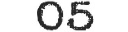

In [114]:
# original image
n=9
#100
img_orig=cv2.imread(orig_paths[n],0)
left=np.ceil((128-img_orig.shape[1])/2).astype(int)
right=128-img_orig.shape[1]-left
img_orig=np.pad(img_orig, ((0, 0), (left, right)),'maximum')
img_orig=cv2.resize(img_orig,(128,32),cv2.INTER_CUBIC)
Image.fromarray(img_orig)

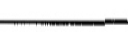

In [109]:
# patches
m=0
#0,5
img_line=cv2.imread(patchHorizFiles[m],0)
img_box=cv2.imread(patchBoxesFiles[m],0)
Image.fromarray(cv2.resize(img_line,(128,32),cv2.INTER_CUBIC))

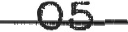

In [110]:
# patched
patched,imlabel=merge_patch_box_random_fl(img_orig,img_line)
#merge_patch_horiz_random_fl
Image.fromarray(patched)

In [111]:
input_images=np.expand_dims(patched,-1)
input_images=np.expand_dims(input_images,0)

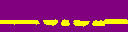

In [112]:
#mask
mask_grey=model.inferBatch(input_images)[0].astype(np.uint8)
mask=cv2.cvtColor(mask_grey,cv2.COLOR_GRAY2RGB)
mask[mask_grey==1]=[255,255,0]
mask[mask_grey!=1]=[128,0,128]
Image.fromarray(mask)

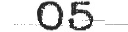

In [113]:
#cleaned image
image_cleaned=model.imageClean2(input_images)[0].astype(np.uint8)
Image.fromarray(image_cleaned)

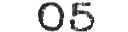

In [115]:
#dilate+erode
kernel = np.ones((2,2), np.uint8)
img_cl=cv2.dilate(image_cleaned, kernel, iterations=1)
img_cl=cv2.erode(img_cl, kernel, iterations=1)
Image.fromarray(img_cl)

In [118]:
#save
cv2.imwrite(test_dir+'orig.jpg',img_orig)
cv2.imwrite(test_dir+'artifact.jpg',cv2.resize(img_line,(128,32),cv2.INTER_CUBIC))
cv2.imwrite(test_dir+'patched.jpg',patched)
cv2.imwrite(test_dir+'predict_mask.jpg',mask)
cv2.imwrite(test_dir+'cleaned.jpg',image_cleaned)
cv2.imwrite(test_dir+'dilate_erode_cleaned.jpg',img_cl)

True

# Model Initiate

In [5]:
model=Model(args, experiment, loss_weight=[0.5,0.5], mustRestore=False)

Instructions for updating:
Colocations handled automatically by placer.
GGG
[None, 32, 128, 1]
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


0 conv1: (?, ?, ?, 32)
0 conv2: (?, ?, ?, 32)
1 conv1: (?, ?, ?, 64)
1 conv2: (?, ?, ?, 64)
2 conv1: (?, ?, ?, 128)
2 conv2: (?, ?, ?, 128)
1 h_deconv: (?, ?, ?, 64)
1 h_deconv_concat: (?, ?, ?, ?)
1 h_conv1_post_deconv: (?, ?, ?, 64)
1 h_conv2_post_deconv: (?, ?, ?, 64)
0 h_deconv: (?, ?, ?, 32)
0 h_deconv_concat: (?, ?, ?, ?)
0 h_conv1_post_deconv: (?, ?, ?, 32)
0 h_conv2_post_deconv: (?, ?, ?, 32)
0 outmap: (?, ?, ?, 2)
(?, ?, ?, 2)
loss: ()
INFO:tensorflow:Summary name loss/cross_entropy (raw) is illegal; using loss/cross_entropy__raw_ instead.


INFO:tensorflow:Summary name loss/cross_entropy (raw) is illegal; using loss/cross_entropy__raw_ instead.


INFO:tensorflow:Summary name loss/total_loss (raw) is illegal; using loss/total_loss__raw_ instead.


INFO:tensorflow:Summary name loss/total_loss (raw) is illegal; using loss/total_loss__raw_ instead.


toto_loss_shape: Tensor("loss/total_loss:0", shape=(), dtype=float32)
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


Python: 3.5.2 (default, Nov 12 2018, 13:43:14) 
[GCC 5.4.0 20160609]
Tensorflow: 1.12.0-rc0
Instructions for updating:
Use standard file APIs to check for files with this prefix.


Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from /root/ckpt/segnet_unet_hvbw_all_combine_100_epoches/model-51


INFO:tensorflow:Restoring parameters from /root/ckpt/segnet_unet_hvbw_all_combine_100_epoches/model-51


Init with stored values from /root/ckpt/segnet_unet_hvbw_all_combine_100_epoches/model-51
